<a href="https://colab.research.google.com/github/KacperKon/meye/blob/master/meye_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook allows you to track pupil from multiple experiments in Google Colab.**

The assumed structure of the data is:
- a separate folder per experiment (for which the same analysis parameters will be applied)
- each folder can contain multiple video files (e.g., one video per trial); the results will be stored in a single data frame.

To access the data, you will either need to have them on your Google Drive or upload them from your local storage (slower).

You will also need to download the pretrained model (https://github.com/fabiocarrara/meye/releases/download/v0.1.1/meye-2022-01-24.h5).

Based on notebook created by Fabio Carrara (https://github.com/fabiocarrara/meye/blob/master/pupillometry-offline-videos.ipynb).

Kacper Kondrakiewicz, 04/2025.

In [10]:
#!pip install -q opencv-python-headless scikit-image

# Import required packages for this notebook
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
%matplotlib inline
import cv2 as cv
from skimage.measure import label, regionprops
from google.colab import files
from google.colab import drive
from tensorflow.keras.models import load_model
from IPython.display import HTML, display
import time
import glob


In [11]:
# Define functions; no need to change anything here

def upload_many(experiments, home_dir = '/content'):
  ### Upload multiple video files from manually chosen directory ###

  # Point Colab to which videos to upload for each experiment
  all_videos = []
  for exp in experiments:

    # Go to default data directory and create folders for each experiment
    os.chdir(home_dir)
    if not os.path.exists(exp):
      os.makedirs(exp)
    os.chdir(exp)

    # Manually upload for each experiment - currently I have no better solution
    print('\n', 'Upload files for experiment: ' + exp)
    data_exp = files.upload()

    # Store the paths for all experiments and videos
    fnames = list(data_exp.keys())
    fpaths = [home_dir + '/' + exp + '/' + fname for fname in fnames]
    all_videos.append(fpaths)

  os.chdir(home_dir)
  return all_videos


def search_drive(experiments, exp_dir = '/content/drive/My Drive'):
  ### Search video files on your Google drive ###
  all_videos = []
  for exp in experiments:
    fdir = exp_dir + '/' + exp
    fpaths = glob.glob(fdir + '/*.avi')
    fpaths = sorted(fpaths)

    all_videos.append(fpaths)

  return all_videos


def defineROI(frame, TOPLEFT, ROIWIDTH):
    fHeight, fWidth = frame.shape
    cropL = TOPLEFT[0]
    cropR = TOPLEFT[0]+ROIWIDTH
    cropT = TOPLEFT[1]
    cropB = TOPLEFT[1]+ROIWIDTH

    # Default crop is the selected crop is out of the image boundaries
    if (any(np.array([cropT,cropB])>fHeight)) or (any(np.array([cropL,cropR])>fWidth)):
        print('Crop limits exceed image size. Performing a default crop instead.')
        cropL = round((fWidth-ROIWIDTH) / 2)
        cropR = round((fWidth+ROIWIDTH) / 2)
        cropT = round((fHeight-ROIWIDTH) / 2)
        cropB = round((fHeight+ROIWIDTH) / 2)

    return cropL, cropR, cropT, cropB


def inputShape(model):
    requiredFrameSize = model.input.shape[1:3]
    return requiredFrameSize


def cropResize(sourceImg, inputShape, cropL, cropR, cropT, cropB):
    cropped = sourceImg[cropT:cropB, cropL:cropR]
    cropped = cv.resize(cropped,tuple(requiredFrameSize))
    return cropped


def morphProcessing(sourceImg, thr, imclosing):
    # Binarize
    binarized = sourceImg > thr
    # Divide in regions and keep only the biggest
    label_img = label(binarized)
    regions = regionprops(label_img)
    if len(regions)==0:
        morph = np.zeros(sourceImg.shape, dtype='uint8')
        centroid = (np.nan, np.nan)
        return (morph, centroid)
    regions.sort(key=lambda x: x.area, reverse=True)
    centroid = regions[0].centroid # centroid coordinates of the biggest object
    if len(regions) > 1:
        for rg in regions[1:]:
            label_img[rg.coords[:,0], rg.coords[:,1]] = 0
    label_img[label_img!=0] = 1
    biggestRegion = (label_img*255).astype(np.uint8)
    # Morphological
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(imclosing,imclosing))
    morph = cv.morphologyEx(biggestRegion, cv.MORPH_CLOSE, kernel)
    return (morph, centroid)


def correctGamma(image, gamma = 0.5):
  lookUpTable = np.empty((1,256), np.uint8)
  for i in range(256):
    lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
  outImg = cv.LUT(image, lookUpTable)
  return outImg


## Other image corrections, currently not implemented in the main function ##
# A) Adjust contrast and brightness
def correctContrast(image, alpha=1.0, beta=0):
  # Adjust brigthness (beta) and contrast (alpha)
  alpha = float(alpha)
  beta = int(beta)
  outImg = np.zeros(image.shape, image.dtype)
  for y in range(image.shape[0]):
    for x in range(image.shape[1]):
      outImg[y,x] = np.clip(alpha*image[y,x] + beta, 0, 255)
  return outImg
# B) Sharpen the image
def sharpen(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened
#### For me these additional corrections didn't really help ####


def readFrame(VIDEOPATH, FRAMENUMBER=[]):
  # Read a single frame from the video
  # If FRAMENUMBER is [], a random frame will be selected
  cap = cv.VideoCapture(VIDEOPATH)
  try:
      numOfFrames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
      if not FRAMENUMBER: # if frame number not given, choose random
          FRAMENUMBER = np.random.randint(1, high=numOfFrames)
      if FRAMENUMBER>numOfFrames:
          print('requested a frame (#{}) beyond video length ({}).'.format(FRAMENUMBER,numOfFrames),end='')
          print(' Analyzing last frame instead')
          FRAMENUMBER=numOfFrames
      cap.set(cv.CAP_PROP_POS_FRAMES,FRAMENUMBER-1)
      # -1 because CAP_PROP_FRAME_COUNT is 1-based while CAP_PROP_POS_FRAMES is 0-based

      # Read a frame from the
      _, frame = cap.read()
      # Convert to grayscale
      frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
  except:
      print('An error occurred while getting a frame for the video.')
  finally:
      cap.release()

  return frame


def predictFrame(croppedFrame, model):
  #### Predict pupil size and position on a single frame ####
  networkInput = croppedFrame.astype(np.float32) / 255.0  # convert from uint8 [0, 255] to float32 [0, 1]
  networkInput = networkInput[None, :, :, None]  # add batch and channel dimensions
  mask, info = model(networkInput)
  return mask, info


def predictVideo(cap, model, cropL=0, cropR=128, cropT=0, cropB=128,
                 GAMMA=1, thr=0.3, imclosing=10):
  #### Process a whole video (==cap) and store results as a dataframe ####

  numFrames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

  # Prepara data frame for storing results
  df = pd.DataFrame(0.0, index=np.arange(numFrames),
    columns=['frameN','pupilSizeRaw','pupCntr_x','pupCntr_y','eyeProb','blinkProb'])

  try:
      for i in range(numFrames):
          _, frame = cap.read()
          frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

          # Preprocess image
          croppedFrame = cropResize(frame, inputShape, cropL, cropR, cropT, cropB)
          if INVERTIMAGE:
              croppedFrame = cv.bitwise_not(croppedFrame)
          croppedFrame = correctGamma(croppedFrame, GAMMA)

          # Run the model
          mask, info = predictFrame(croppedFrame, model)
          prediction = mask[0,:,:,0]
          morphedMask, centroid = morphProcessing(prediction, thr, imclosing)

          # Extract infos
          eyeProbability = info[0,0]
          blinkProbability = info[0,1]

          #Save values for the current frame
          df.loc[i, 'frameN'] = int(i)
          df.loc[i, 'pupilSizeRaw'] = np.sum(morphedMask)/255
          df.loc[i, 'pupCntr_x'] = centroid[1]
          df.loc[i, 'pupCntr_y'] = centroid[0]
          df.loc[i, 'eyeProb'] = eyeProbability.numpy()
          df.loc[i, 'blinkProb'] = blinkProbability.numpy()

          # Print progress
          #if (i!=0) & (i%100==0) :
          #    print('Processing frames... ({}/{})'.format(i,numFrames))
  finally:
      cap.release()

  return df



In [12]:
### UPDATE list of experiments (==folder names) to analyze ###
experiments = ['240709_KK136', '240709_KK140']
# After that you have 2 different options to load your data


In [ ]:
### Option 1 - upload files from your local storage ######
# It's slower but you can upload directly from any location

## Upload the model
#print('Upload the pretrained model (download from (https://github.com/fabiocarrara/meye/releases/download/v0.1.1/meye-2022-01-24.h5)')
#model_file = files.upload()
#model_path = list(model_file.keys())[0]
#model = load_model(model_path)

## And the video files
#all_videos = upload_many(experiments)

In [13]:
### Option 2 - use files from Google drive ######

drive.mount('/content/drive', force_remount=True)
exp_dir = '/content/drive/My Drive/meye'
model_path = '/content/drive/My Drive/meye/meye-2022-01-24.h5'

model = load_model(model_path)
all_videos = search_drive(experiments, exp_dir)
print(all_videos)

Mounted at /content/drive


[['/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000000.avi', '/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000001.avi', '/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000002.avi', '/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000003.avi', '/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000004.avi', '/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000005.avi', '/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000006.avi', '/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000007.avi', '/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000008.avi', '/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000009.avi', '/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000010.avi', '/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000011.avi', '/content/drive/My Drive/meye/240709_KK136/20240709_run000_00000012.avi', '/content/drive/My Drive/meye/240709

In [14]:
# Sanity check for number of files imported

n_exp = len(all_videos)
n_videos = [len(x) for x in all_videos]

print('Uploaded {n} experiments with {n2} videos'.format(
      n=n_exp, n2=str(n_videos)))

requiredFrameSize = inputShape(model)
print('ROI will be resized to: ' + str(requiredFrameSize[0]) + 'x' + str(requiredFrameSize[0]) + ' pixels')
print('Proceed to ROI selection')


Uploaded 2 experiments with [164, 164] videos
ROI will be resized to: 128x128 pixels
Proceed to ROI selection


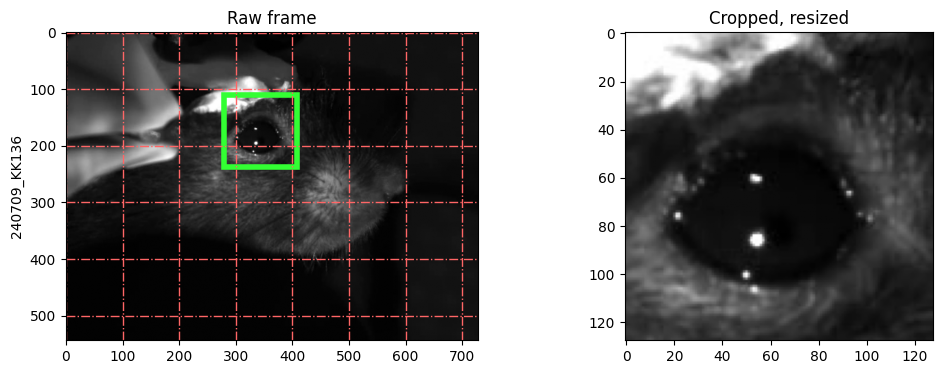

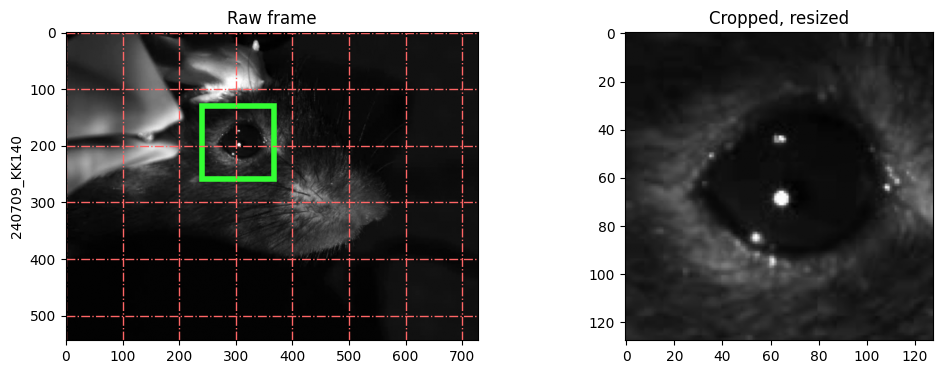

In [16]:
# SELECT ROI
# Manually select a square ROI for the eye, by specifying the XY coordinates
# and the width of the square in pixels
# ---------------------------------------------------
TOPLEFT = [(280,110),
           (240,130),
           (300,160),
           (260,120)] # X,Y coordinates for each experiment

# Set ROI size to the input required by the model
ROIWIDTH = [requiredFrameSize[0]] * n_exp # width on the square ROI in pixels
# If that doesn't make sense for your videos, choose any other number
# However, resizing might affect image quality
# ---------------------------------------------------


for ii in range(n_exp):
  frame = readFrame(all_videos[ii][0])

  # Crop frame
  cropL, cropR, cropT, cropB = defineROI(frame, TOPLEFT[ii], ROIWIDTH[ii])
  cropped = cropResize(frame, inputShape, cropL, cropR, cropT, cropB)

  # Create a Rectangle patch
  rect = ptch.Rectangle((cropL,cropT),ROIWIDTH[ii],ROIWIDTH[ii],
                        linewidth=4,edgecolor=[.2,1,.2],facecolor='none')

  # Visual plotting
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
  ax1.set_ylabel(experiments[ii])
  ax1.imshow(frame, cmap='gray')
  ax1.add_patch(rect)
  ax1.set_title('Raw frame')
  ax2.imshow(cropped, cmap='gray')
  ax2.set_title('Cropped, resized')
  ax1.grid(color=[1,.4,.4], linewidth=1, linestyle='-.')
  plt.show()

Experiment: 240709_KK136
Eye Probability: 99.99%
Blink Probability: 0.02%


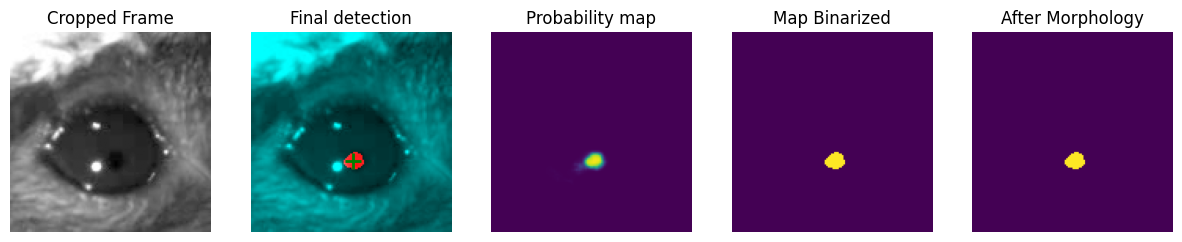

Experiment: 240709_KK140
Eye Probability: 100.00%
Blink Probability: 0.05%


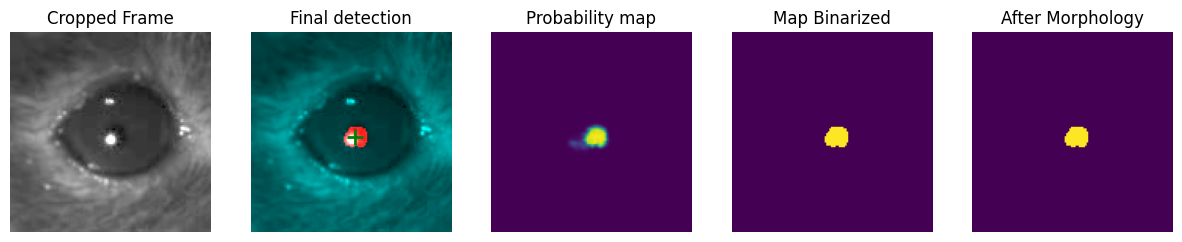

In [25]:
# EDIT ANALYSIS PARAMETERS & TEST NETWORK ON A RANDOM FRAME
# JUST RUN IT A FEW TIMES TO SEE DIFFERENT EXAMPLES
# ---------------------------------------------------
FRAMENUMBER = [] # frame number to analyze. If [] a random frame will be taken
THRESHOLD = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3] # probability threshold for image binarization
IMCLOSING = [13, 13, 13, 13, 13, 13] # pixel radius of circular kernel for morphological closing
GAMMA = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # the smaller, the more amplified the contrast
INVERTIMAGE = False
# ---------------------------------------------------

for ii in range(n_exp):

  # Read and preprocess a frame
  video_num = np.random.randint(0, n_videos[ii]) # a random video
  frame = readFrame(all_videos[ii][video_num])
  cropL, cropR, cropT, cropB = defineROI(frame, TOPLEFT[ii], ROIWIDTH[ii])
  croppedFrame = cropResize(frame, inputShape, cropL, cropR, cropT, cropB)

  if INVERTIMAGE:
      croppedFrame = cv.bitwise_not(croppedFrame)

  croppedFrame = correctGamma(croppedFrame, GAMMA[ii])

  # Detect pupil on a single frame
  mask, info = predictFrame(croppedFrame, model)

  # Extract infos
  prediction = mask[0,:,:,0]
  eyeProbability = info[0,0]
  blinkProbability = info[0,1]

  morphedMask, centroid = morphProcessing(prediction, THRESHOLD[ii], IMCLOSING[ii])

  # Generate falsecolor image
  falseColor = np.dstack((morphedMask, croppedFrame, croppedFrame))

  # OUTPUT
  print('Experiment: {ee}'.format(ee=experiments[ii]))
  print('Eye Probability: {:4.2%}'.format(eyeProbability))
  print('Blink Probability: {:4.2%}'.format(blinkProbability))

  fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,5))
  ax[0].imshow(croppedFrame, cmap='gray')
  ax[0].set_title('Cropped Frame')

  ax[1].imshow(falseColor)
  ax[1].plot(centroid[1], centroid[0], marker='+', markersize=12, mew=2, mec='g')
  ax[1].set_title('Final detection')

  ax[2].imshow(prediction, vmin=0, vmax=1)
  ax[2].set_title('Probability map')

  ax[3].imshow(prediction > THRESHOLD[ii])
  ax[3].set_title('Map Binarized')

  ax[4].imshow(morphedMask)
  ax[4].set_title('After Morphology')



  for a in ax.reshape(-1):
      a.axis('off')
  plt.show()

In [ ]:
# Run the prediction on all experiments and videos

for ii in range(n_exp):

  # Display progress
  print('Experiment: ' + experiments[ii])
  start = time.time()
  progress_txt = display('Video 1/' + str(n_videos[ii]) +
                         ', elapsed time: 0.0 sec', display_id=True)

  # Loop through videos
  for ff in range(n_videos[ii]):

    # Read video & find ROI
    cap = cv.VideoCapture(all_videos[ii][ff])
    vidname = os.path.basename(all_videos[ii][ff])
    if ff==0:
      frame0 = readFrame(all_videos[ii][ff], 0)
      cropL, cropR, cropT, cropB = defineROI(frame0, TOPLEFT[ii], ROIWIDTH[ii])

    # Analyze
    df_tmp = predictVideo(cap, model, cropL, cropR, cropT, cropB,
                    GAMMA[ii], THRESHOLD[ii], IMCLOSING[ii])
    df_tmp['fname'] = vidname # add video file name to results

    if ff==0: # store results
      df = df_tmp
    else:
      df = pd.concat([df, df_tmp], ignore_index=True)

    # Check for proportion of failed detections (pupil smaller than 1 pixel)
    n_nans = sum(df['pupilSizeRaw']<1) / len(df['pupilSizeRaw']) * 100

    # Update progress information
    now = time.time()
    progress_txt.update('Video ' + str(ff+1) + '/' + str(n_videos[ii])
        + ', elapsed time: ' + str(np.round(now-start)) + ' sec, ' +
        str(np.round(n_nans,2)) + '% failed detections')

  # Write file with the dataframe and download
  fname = experiments[ii] + '_pupil.h5'
  df.to_hdf(fname, key='df', format = 't', mode = 'w') # overwrite file if exists
  files.download(fname)
  print('File saved on Colab machine; will be downloaded when this cell stops running')

  # If Google drive is mounted, copy the file also there
  if os.path.isdir(exp_dir):
    try:
      fpath = os.getcwd() + '/' + fname
      shutil.copy(fpath, exp_dir)
      print('File copied also to Google Drive')
    except:
      print('Failed to copy the file to Google Drive')

print('Finished!')

# If the files were not downloaded, it's possible that your browser blocked it
# You can download manually from the pop-up menu on the left



Experiment: 240709_KK136


'Video 164/164, elapsed time: 5049.0 sec, 0.12% failed detections'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File saved on Colab machine; will be downloaded when this cell stops running
File copied also to Google Drive
Experiment: 240709_KK140


'Video 86/164, elapsed time: 2715.0 sec, 0.23% failed detections'

In [ ]:
#plt.plot(df['eyeProb']*100-99)
plt.plot(df['pupilSizeRaw'])

In [ ]:
# EDIT PARAMETERS
# ---------------------------------------------------
BLINK_THRESH = 0.3
MEDIAN_WINDOW = 7
# ---------------------------------------------------

%matplotlib inline
# Remove blinks and interpolate the curve
isBlinking = df['blinkProb'] > BLINK_THRESH
processedPupil = df['pupilSizeRaw'].copy()
processedPupil[isBlinking] = np.nan
processedPupil.interpolate(inplace=True)
# Moving median filter
processedPupil = processedPupil.rolling(MEDIAN_WINDOW,min_periods=1, center=True).median()
df['processedPupil'] = processedPupil

# Plotting
f, ax = plt.subplots(figsize=(14,4))
ax.plot(df['pupilSizeRaw'],label='Raw pupil')
ax.plot(processedPupil, label='Preprocessed Pupil')
ax.fill_between(df['frameN'], ax.get_ylim()[0], ax.get_ylim()[1],
                where=isBlinking, interpolate=True,
                facecolor='red', alpha=1,label='Blinking')
ax.set_title('Pupil Area Preprocessing')
ax.set_xlabel('Frame Number')
ax.set_ylabel('Pupil Area (px)')
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc=0)
plt.show()